# Glare Reduction Function

From https://github.com/ducthotran2010/glare-reduction/blob/master/README.md#Reduce-glare-filter

In [1]:
import cv2
import numpy
import math
from PIL import Image, ImageEnhance

# =================CONVERT================
def CV2_to_PIL_img(cv2_im):
    """
    Convert Opencv's BGR image to PIL image

    Input:
    --------
        cv2_im: Opencv's BGR

    Output: 
    --------
        PIL Image
    """

    cv2_im = cv2.cvtColor(cv2_im, cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im)
    return pil_im


def PIL_to_CV2_img(img):
    """
    Convert PIL image to Opencv's BGR image

    Input:
    --------
        img: PIL Image

    Output: 
    --------
        Opencv's BGR Image
    """
    cv_image = numpy.array(img.convert('RGB')) 
    cv_image = cv_image[:, :, ::-1].copy() 
    return cv_image
# ========================================



# =========POLYNOMIAL FUNCTIONS===========
def first_polynomial_function(image):
    """
    Implementation of first polynomial function.

    Input:
    --------
        image: Opencv's BGR Image

    More detail at `Documentation.pdf`
    """

    table = numpy.array([1.657766*i-0.009157128*(i**2) + 0.00002579473*(i**3)
		for i in numpy.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


def second_polynomial_function(image):
    """
    Implementation of second polynomial function.

    Input:
    --------
        image: Opencv's BGR Image
    
    More detail at `Documentation.pdf`
    """

    table = numpy.array([
		-4.263256 * math.exp(-14)+1.546429*i-0.005558036*(i**2)+0.00001339286*(i**3)
		for i in numpy.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
# ========================================



# ===========GAMMA CORRECTION ============
def adjust_gamma(image, gamma=1.0):
    """
    Implementation of gamma correction

    Input:
    --------
        image: Opencv's BGR Image
    
    More detail at `Gamma-Correction.pdf`
    """
	
    invGamma = 1.0 / gamma
    table = numpy.array([((i / 255.0) ** invGamma) * 255
		for i in numpy.arange(0, 256)]).astype("uint8")
		    
    return cv2.LUT(image, table)
# ========================================



# =========CONTRAST & BRIGHTNESS==========
def enhance_contrast(image, factor=1.4):
    """
    Enhance contrast base on PIL->ImageEnhance.
    Default suitable factor is 1,4.

    Input:
        image: Opencv's BGR Image
        factor: contrast's factor
    
    Output:
        Enhanced contrast BGR image
    """

    _image = ImageEnhance.Contrast(
        CV2_to_PIL_img(image)
    ).enhance(factor)
    
    return PIL_to_CV2_img(_image)
# ========================================

# =================METHODS================
def reduce_glare(image):
    """
    Mixed 4 filter:
        1. First polynomial function
        2. Gamma correction: g = 0.75
        3. Second polynomial function
        4. Gamma correction: g = 0.8

    Input: BGR Image.\n
    Output: Reduce glare.
    """
    _image = adjust_gamma(
        second_polynomial_function(
            adjust_gamma(
                first_polynomial_function(image), 
                0.75
            )
        ),
        0.8
    )
    return _image


def mix_filter(image):
    """
    Mixed 4 steps:
        1. Reduce glare
        2. Enhance contract: f = 1.6
        3. Reduce glare
        4. Enhance contract: f = 1.4

    Input: BGR Image.\n
    Output: Reduced glare & clearly image.
    """
    _image = enhance_contrast(
        reduce_glare(
            enhance_contrast(
                reduce_glare(image), 
                factor=1.6
            )
        ), 
        factor=1.4
    )
    return _image

# Preprocess New Data - artifact

In [2]:
from tqdm.auto import tqdm
import os

directory = "../new_dataset/US_liver_data"

for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".jpg") or filename.endswith(".png"): 
        
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        
        image = mix_filter(image)

        cv2.imwrite(image_path, image)

  0%|          | 0/17818 [00:00<?, ?it/s]

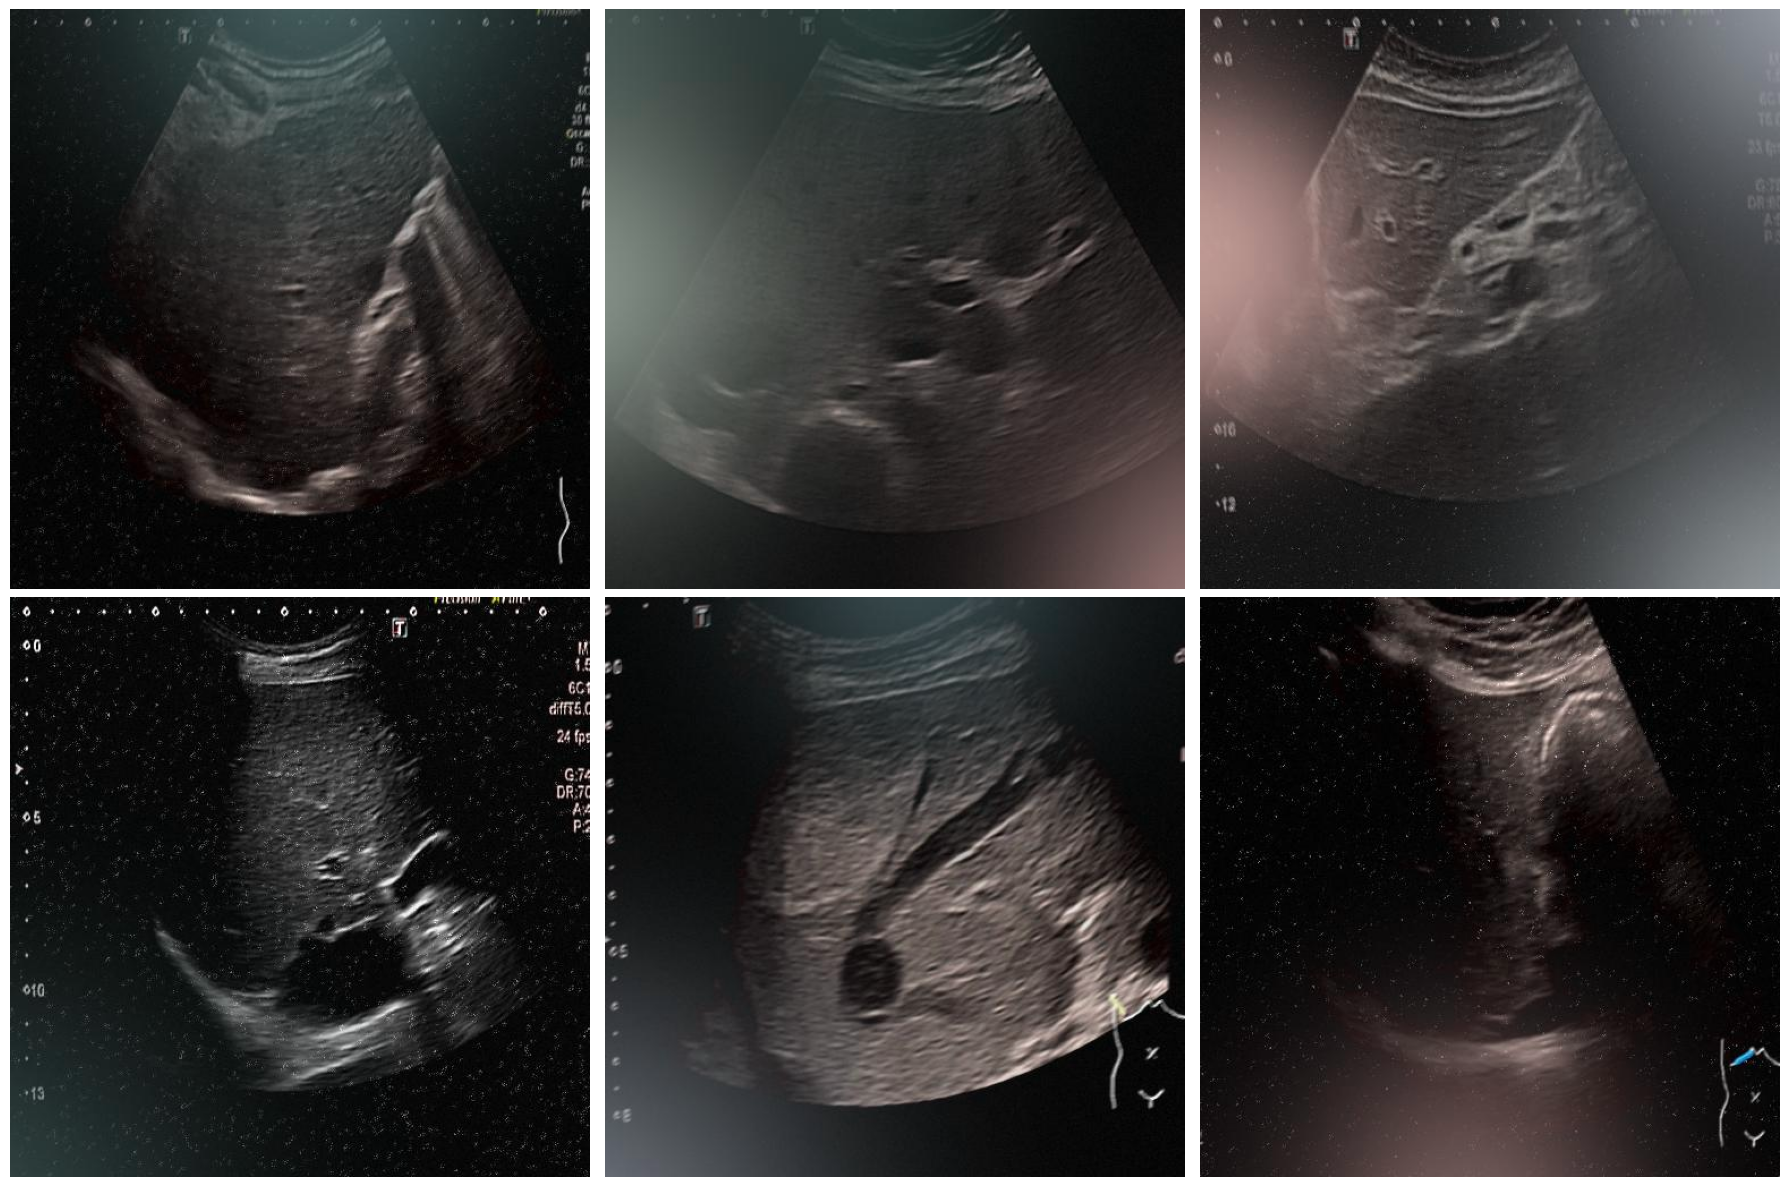

In [38]:
import cv2
import matplotlib.pyplot as plt

def polt_img_arti():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    indices = [ "115211", "97528", "4565", "111711", "40502", "18769"]
    for idx, ax in zip(indices, axes.flatten()):
        image = cv2.imread(f"../new_dataset/Artifact_img/gen_{idx}.jpg")
        # image_rgb = cv2.cvtColor(mix_filter(image), cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()
polt_img_arti()

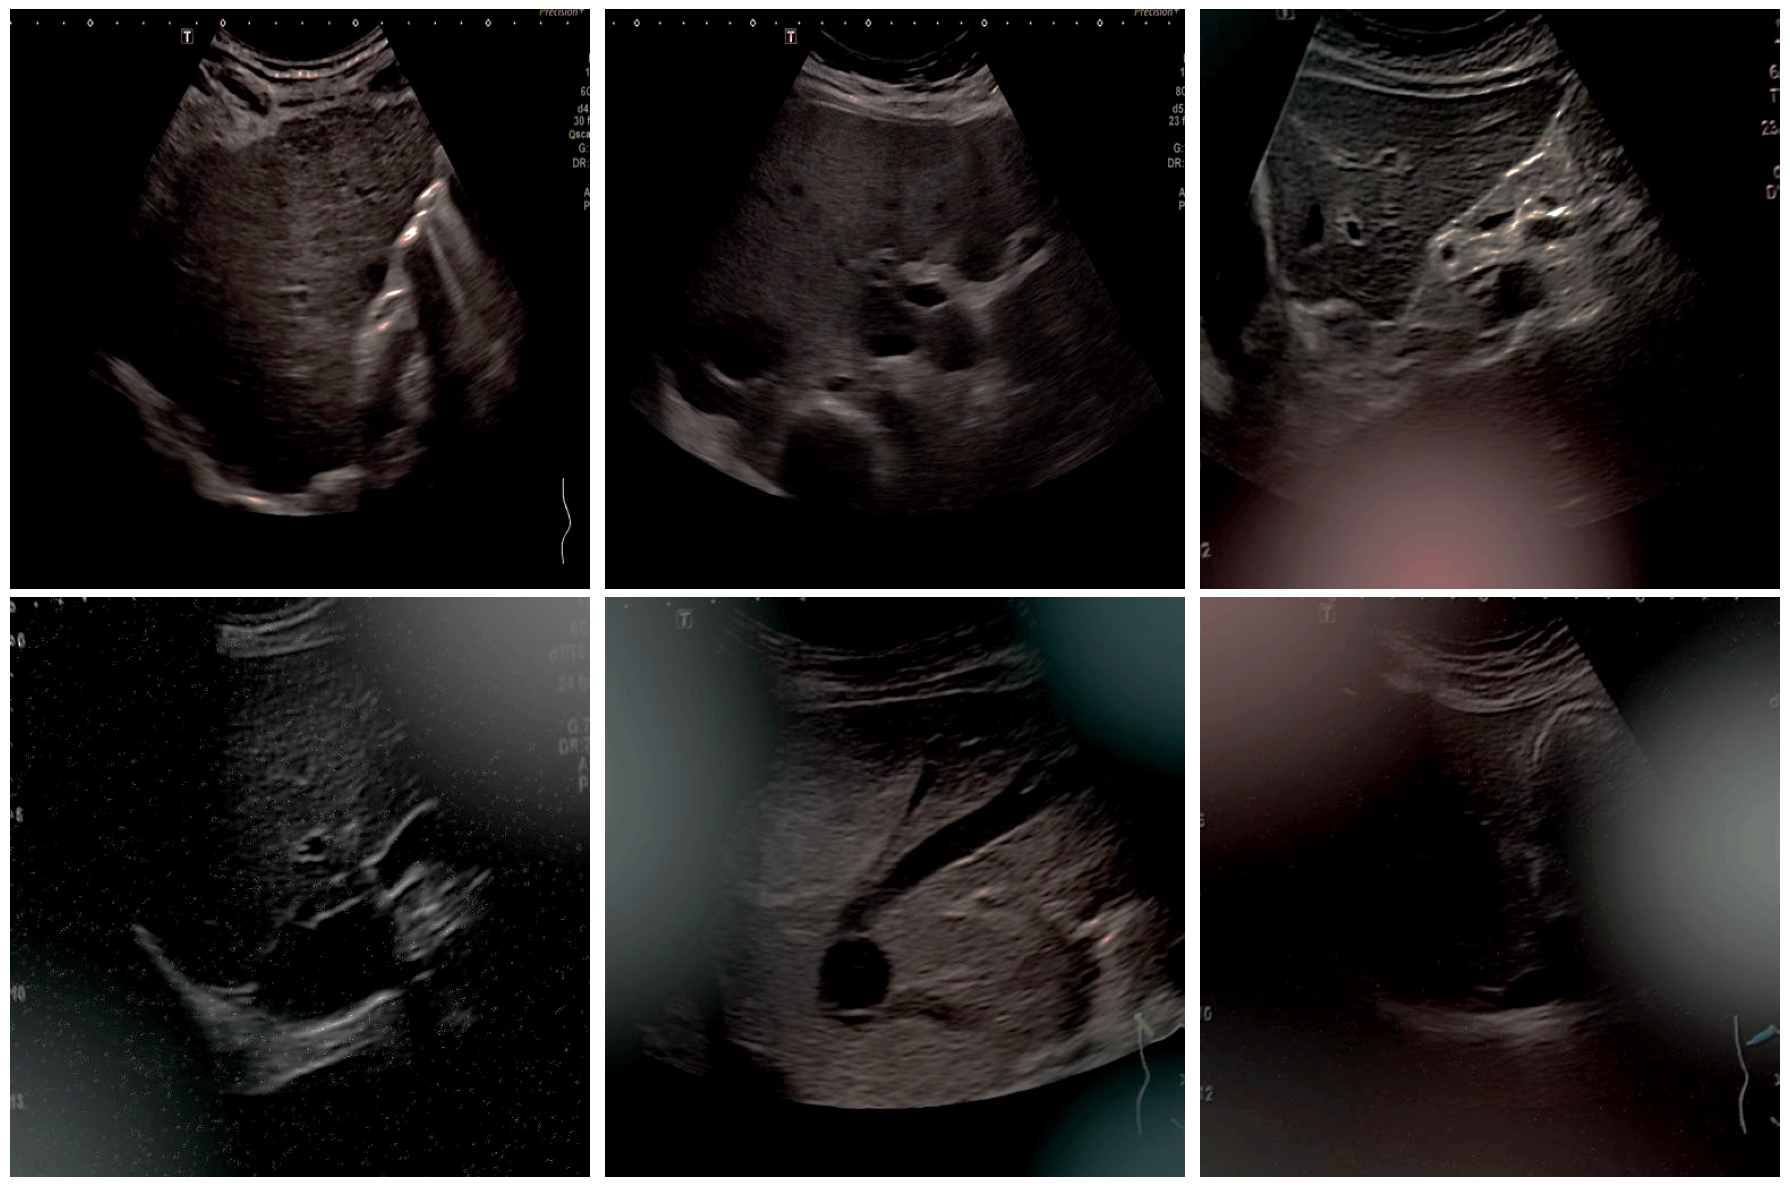

In [41]:
def polt_img_prepro():
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    indices = [ "115211", "97528", "4565", "111711", "40502", "18769"]
    for idx, ax in zip(indices, axes.flatten()):
        image = cv2.imread(f"../new_dataset/US_liver_data/gen_{idx}.jpg")
        # image_rgb = cv2.cvtColor(mix_filter(image), cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()
polt_img_prepro()

## def

In [8]:
import cv2
import matplotlib.pyplot as plt

def detect_img(indices):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Loop through each index and subplot position
    for idx, ax in zip(indices, axes.flatten()):
        try:
            # Load YOLO annotations
            yolo_annotations_file = f"../new_dataset/labels_artifact/{idx}.txt"
            with open(yolo_annotations_file, "r") as f:
                yolo_annotations = f.readlines()
        except:
            print(f"No Label for index {idx}")
            continue

        # Load image
        image_path = f'../new_dataset/US_liver_data/{idx}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image for index {idx}")
            continue

        height, width, _ = image.shape

        # Iterate over YOLO annotations
        for annotation_line in yolo_annotations:
            parts = annotation_line.strip().split()
            label, x_center, y_center, box_width, box_height = map(float, parts)

            # Convert YOLO coordinates to pixel coordinates
            x_min = int((x_center - box_width / 2) * width)
            y_min = int((y_center - box_height / 2) * height)
            x_max = int((x_center + box_width / 2) * width)
            y_max = int((y_center + box_height / 2) * height)

            # Draw bounding box on the image
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Convert image from BGR to RGB for Matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image with the annotation using Matplotlib
        ax.imshow(image_rgb)
        ax.set_title(f"Class: {label}")
        ax.axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()


In [15]:
def read_label(idx):
    # idx = 115211

    try:
      yolo_annotations = []
      yolo_annotations_file = f"../new_dataset/labels_artifact/{idx}.txt"
      with open(yolo_annotations_file, "r") as f:
          yolo_annotations = f.readlines()
    except:
      print("No Label")
      return 

    for annotation_line in yolo_annotations:
        parts = annotation_line.strip().split()
        label, x_center, y_center, box_width, box_height = map(float, parts)

        return label
        # print(label)

# Plot Preprocess already

In [9]:
directory = '../new_dataset/labels_artifact'
file_label_list = []

for filename in os.listdir(directory):

    if os.path.isfile(os.path.join(directory, filename)):

        with open(os.path.join(directory, filename), 'r') as file:

            file_label_list.append(filename)

print(file_label_list[:5])

['gen_25319.txt', 'gen_38527.txt', 'gen_8070.txt', 'gen_14330.txt', 'gen_52924.txt']


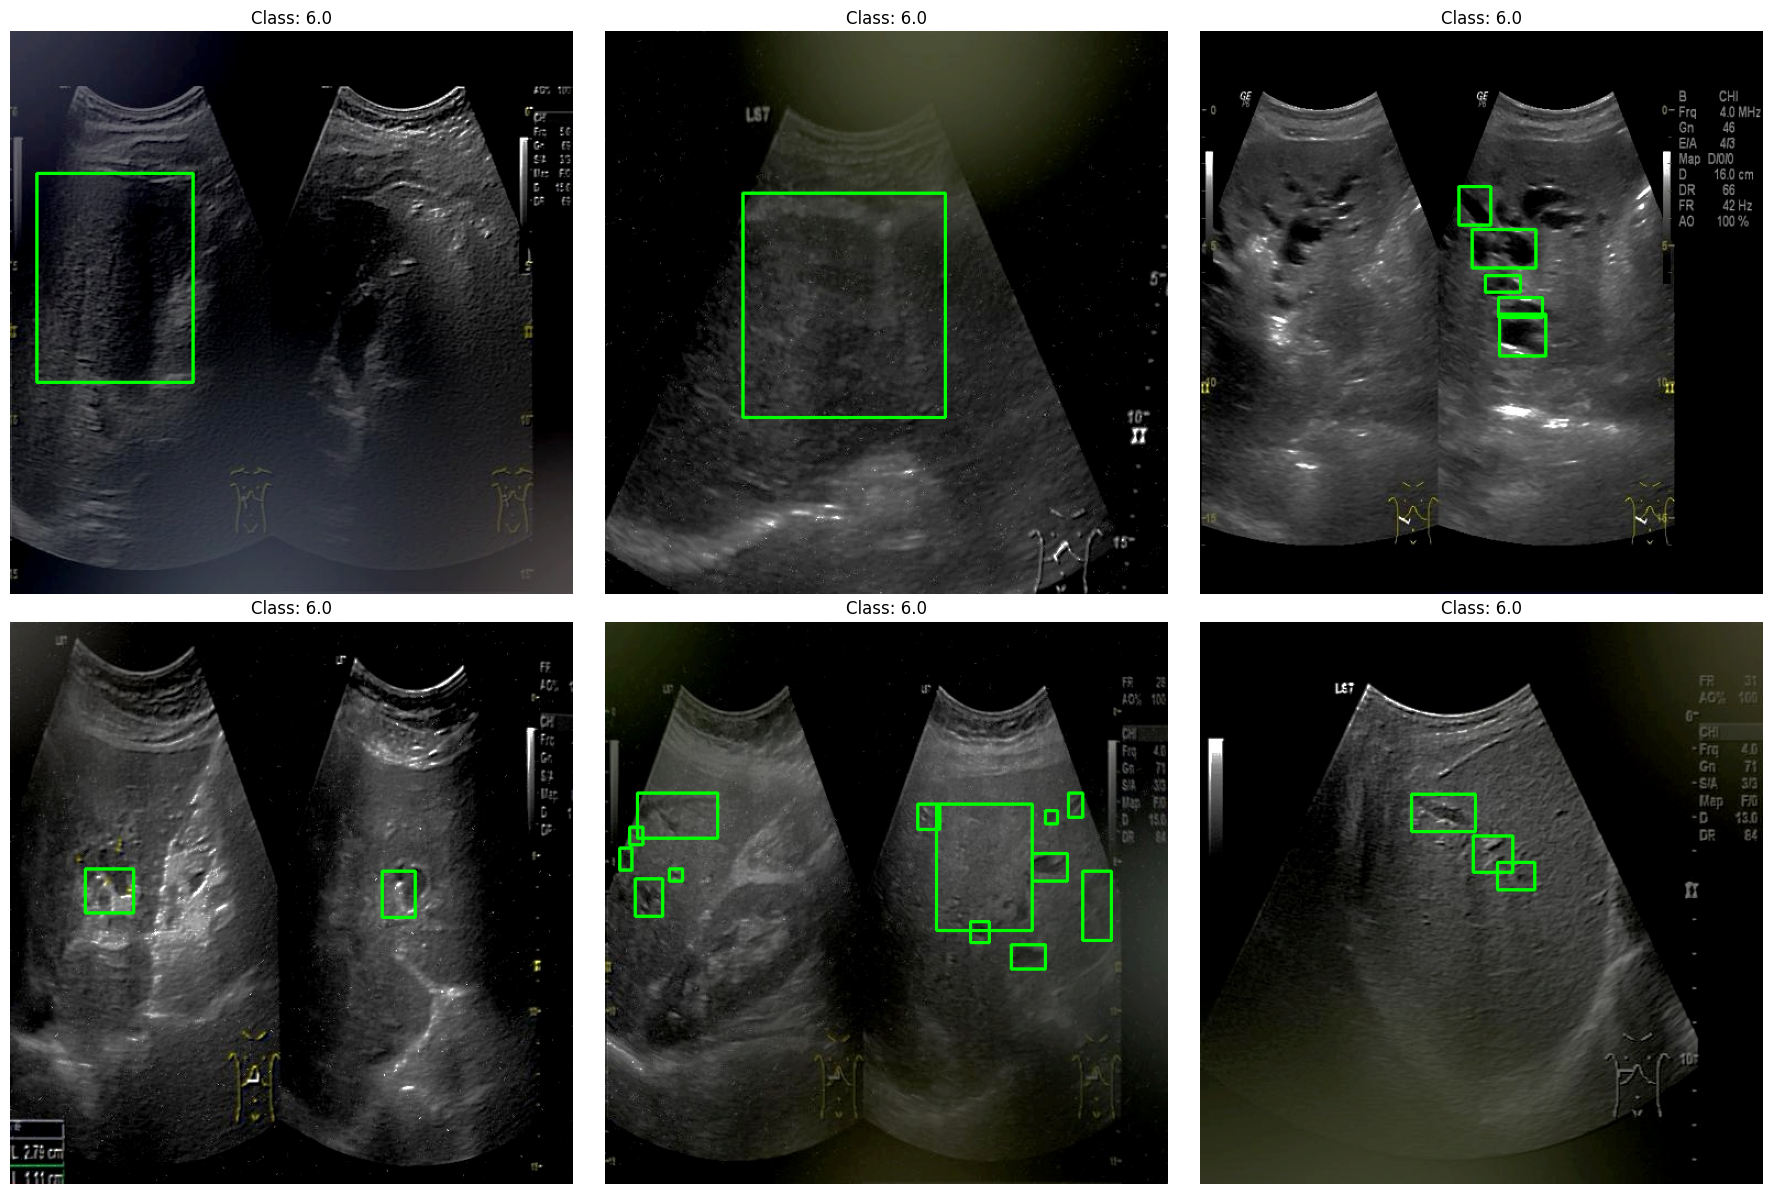

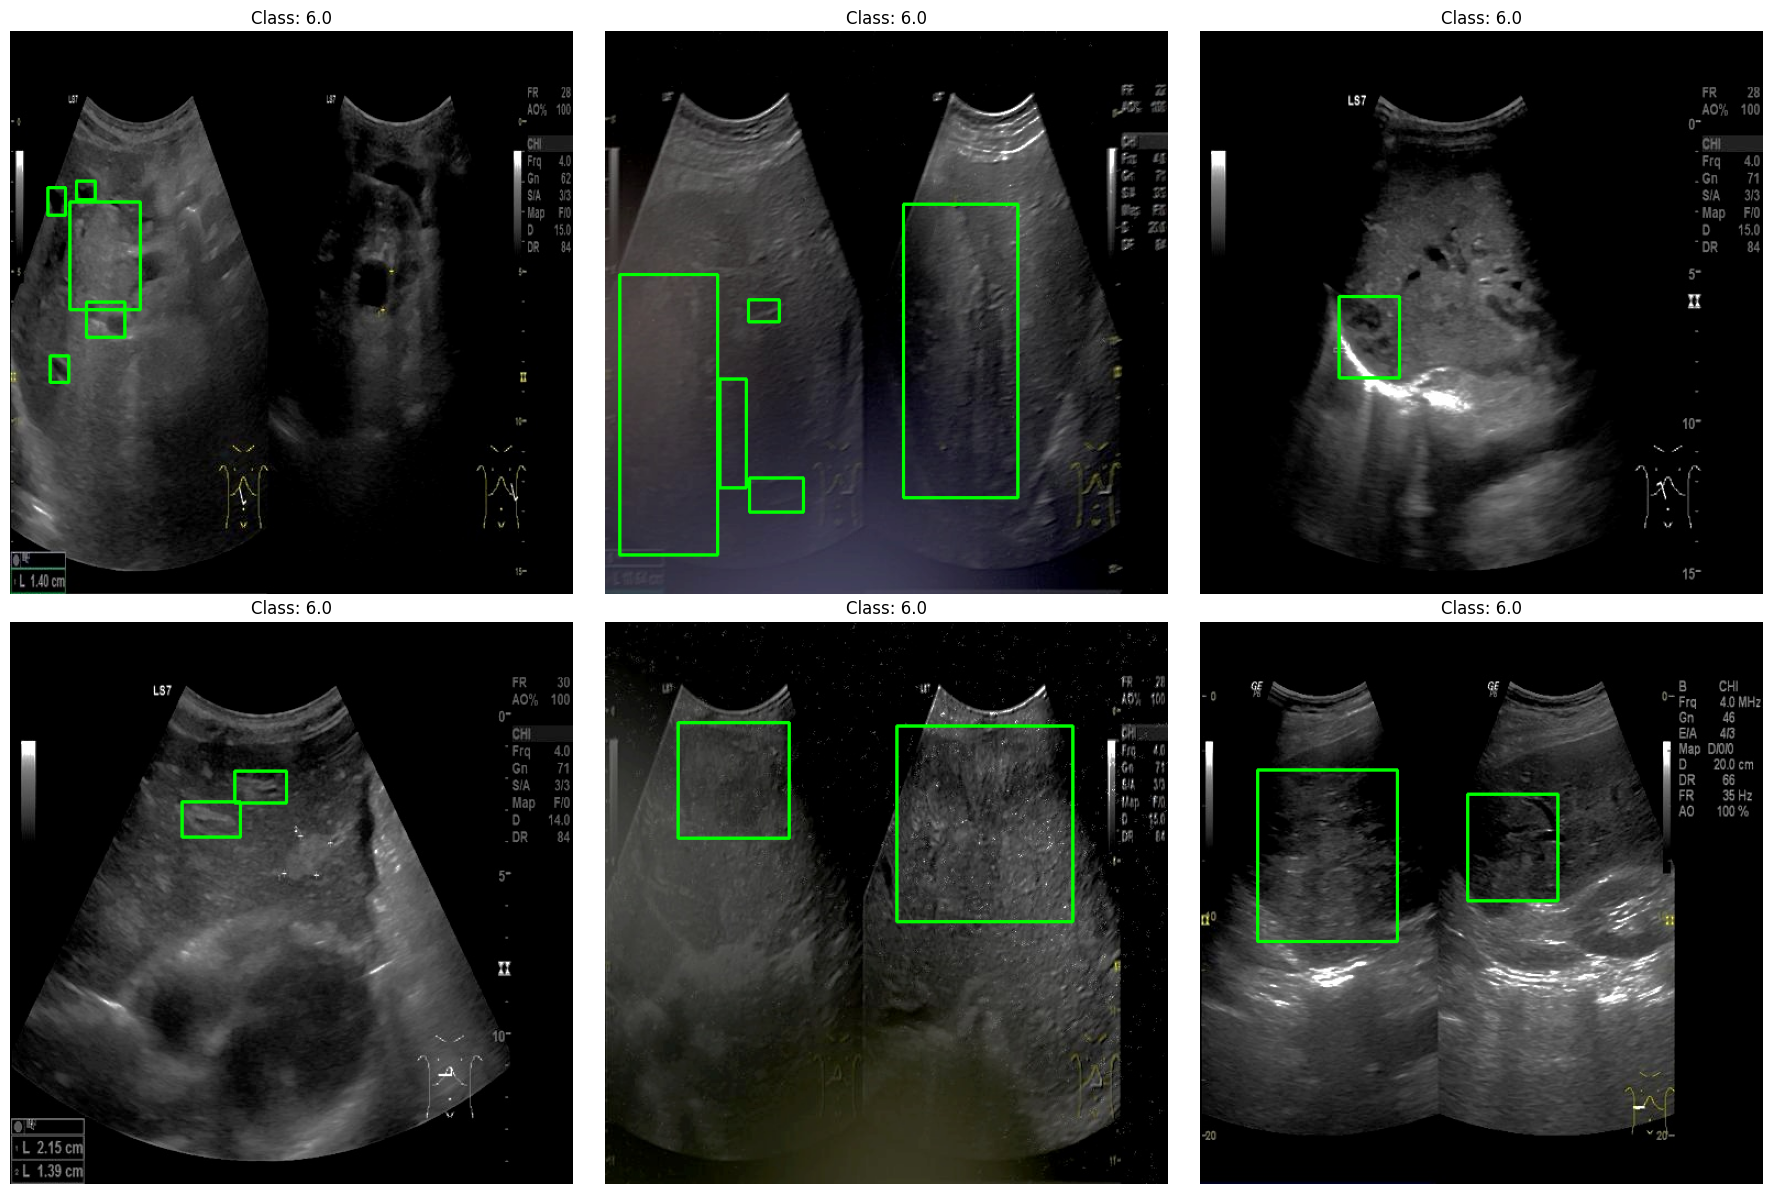

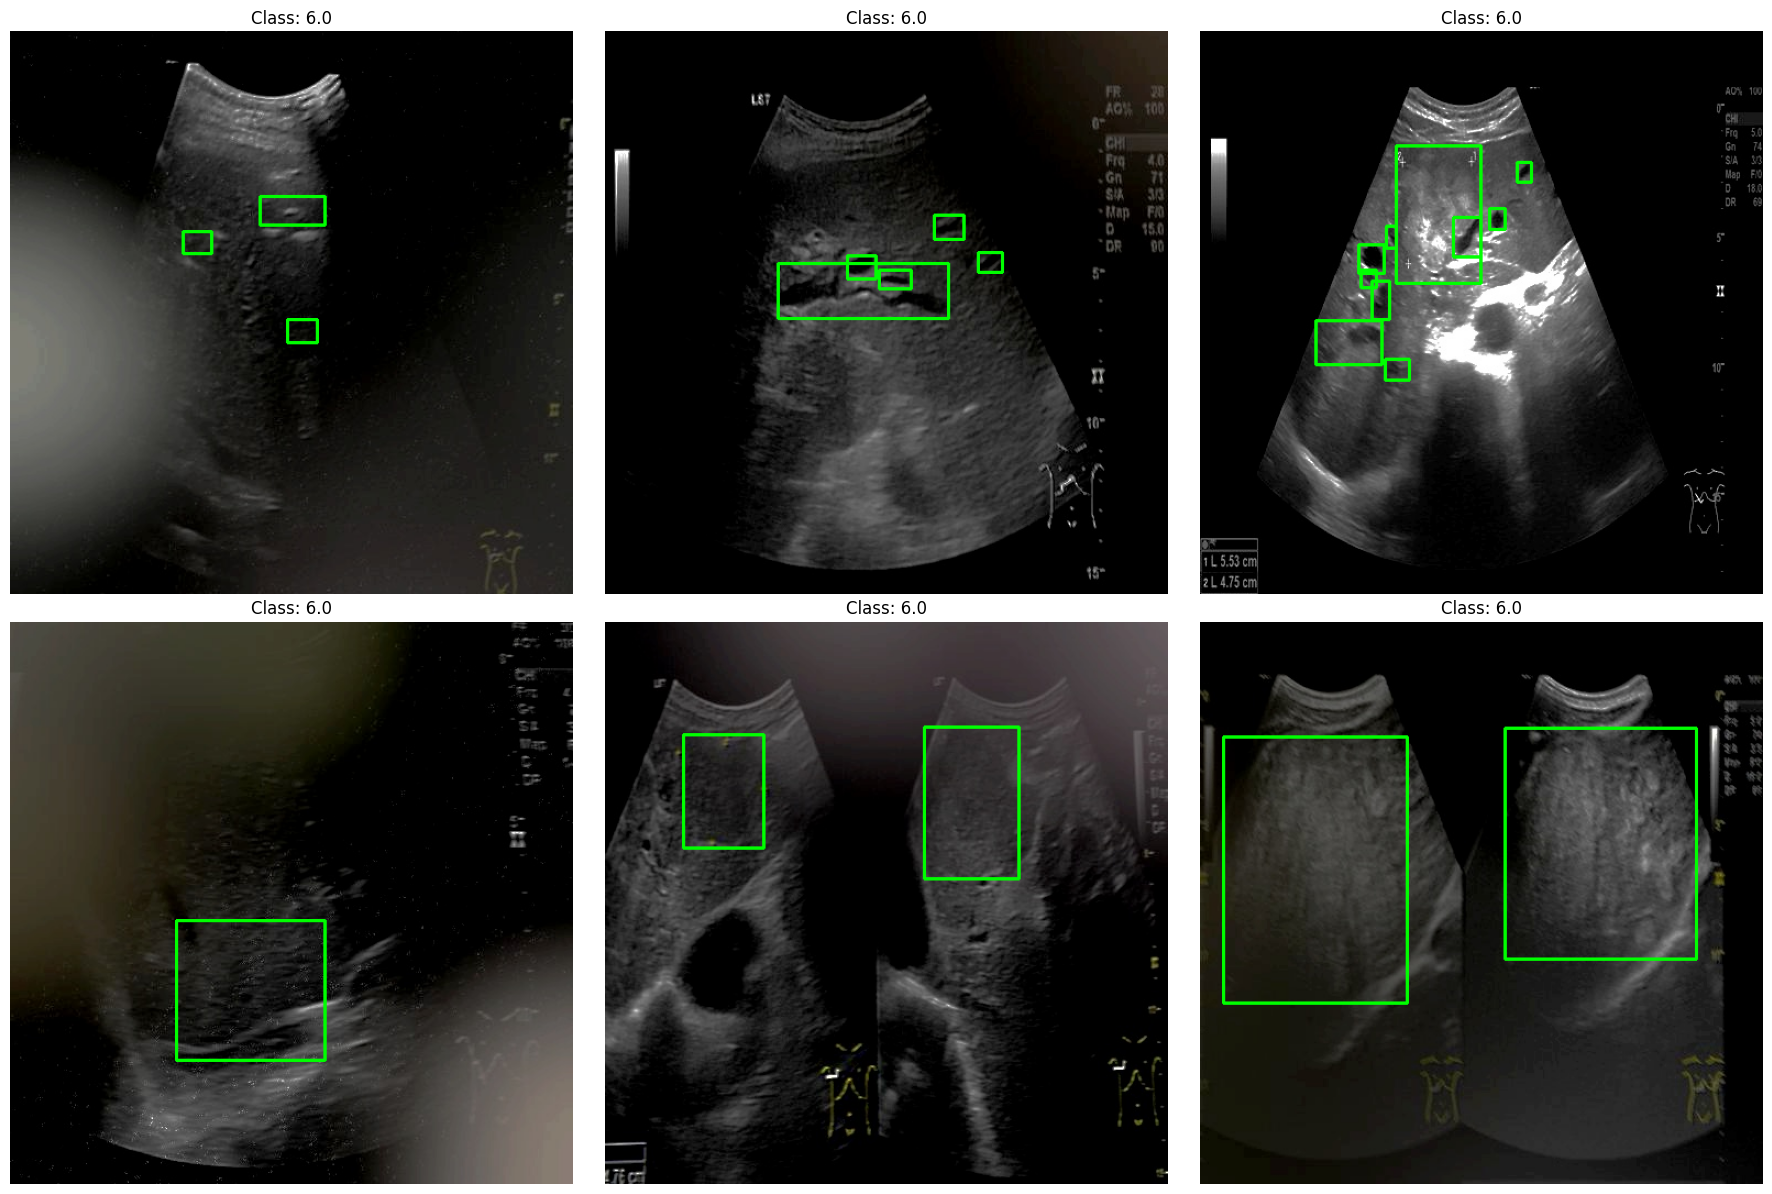

In [20]:
indices = []
num = 0
for file_name in file_label_list[70:]:
  idx = file_name.split(".")
  class_id = read_label(idx[0])
  if class_id == 6:
    indices.append(idx[0])
    if len(indices) == 6:
      detect_img(indices)
      indices = []
      num += 1
      if num == 3: break

# Preprocess Test

In [22]:
import pandas as pd

In [26]:
mol = pd.read_csv("../csv/test_mapping.csv")
mol

image_path  Image File Annotation File  \
0          ./test/test/images\1.jpg       1.jpg           1.txt   
1         ./test/test/images\10.jpg      10.jpg          10.txt   
2       ./test/test/images\1000.jpg    1000.jpg        1000.txt   
3      ./test/test/images\10001.jpg   10001.jpg       10001.txt   
4     ./test/test/images\100077.jpg  100077.jpg      100077.txt   
...                             ...         ...             ...   
5148     ./test/test/images\998.jpg     998.jpg         998.txt   
5149   ./test/test/images\99805.jpg   99805.jpg       99805.txt   
5150    ./test/test/images\9982.jpg    9982.jpg        9982.txt   
5151     ./test/test/images\999.jpg     999.jpg         999.txt   
5152   ./test/test/images\99965.jpg   99965.jpg       99965.txt   

      avg_brightness   Source  
0          95.097465   mobile  
1          91.772285   mobile  
2         110.968967   mobile  
3          32.096696  machine  
4          14.040617  machine  
...              ...      ...  
5148      103.684948   mobile  
5149       71.827596   mobile  
5150       29.727399  machine  
5151       97.415670   mobile  
5152       92.029188   mobile  

[5153 rows x 5 columns]

In [30]:
mol_list = mol[mol['Source'] == "mobile"]['Image File'].tolist()
len(mol_list)

2952

In [31]:
mol_list[:5]

['1.jpg', '10.jpg', '1000.jpg', '100080.jpg', '100196.jpg']

In [33]:
directory = "../test/test/images"
i = 0
for filename in tqdm(os.listdir(directory)):
    if filename in mol_list:
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
        
            image = mix_filter(image)

            cv2.imwrite(image_path, image)

  0%|          | 0/5153 [00:00<?, ?it/s]

# Copy for train

In [43]:
def check_len_train():
    directory = '../dataset/training_data/images/train'
    file_train_list = []

    for filename in os.listdir(directory):

        if os.path.isfile(os.path.join(directory, filename)):

            with open(os.path.join(directory, filename), 'r') as file:

                file_train_list.append(filename)

    print(len(file_train_list))

14448


In [45]:
# def check_len_train():
#     directory = '../dataset/training_data/images/train'
#     file_train_list = []

#     for filename in os.listdir(directory):

#         if os.path.isfile(os.path.join(directory, filename)):

#             with open(os.path.join(directory, filename), 'r') as file:

#                 file_train_list.append(filename)

#     print(len(file_train_list))

In [44]:
import os
import shutil
from tqdm import tqdm

# image
dir1 = '../new_dataset/Artifact_img'
dir2 = '../dataset/training_data/images/train'

for filename in tqdm(os.listdir(dir1)):
    source_file = os.path.join(dir1, filename)
    
    destination_file = os.path.join(dir2, filename)
    
    shutil.copy(source_file, destination_file)

100%|██████████| 17818/17818 [01:29<00:00, 198.47it/s]


In [46]:
check_len_train()

32266


In [47]:
dir1 = '../new_dataset/labels_artifact'
dir2 = '../dataset/training_data/labels/train'

# labels
for filename in tqdm(os.listdir(dir1)):
    source_file = os.path.join(dir1, filename)
    
    destination_file = os.path.join(dir2, filename)
    
    shutil.copy(source_file, destination_file)

100%|██████████| 8998/8998 [00:36<00:00, 243.20it/s]
